In [1]:
# This script demonstrates the capabilities of cluster_slug by using
# it to re-analyze the M31 star clusters catalog of Johnson et al. (2015, ApJ)

# Import the libraries we'll need
from astropy.io import ascii
from astropy.io import fits
import emcee
from astropy import table
from astropy.table import unique, Table, hstack, Column
import sys
from numpy import inf
import numpy as np
import numpy.ma as ma
import time
from matplotlib.pyplot import figure as fig
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
from slugpy.cluster_slug import cluster_slug
from slugpy import * 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

In [9]:
#Imported AP (M33) fits files which include best fit of mass and age data already

m33phot_test=Table.read('/Users/user/Dropbox/m33_zoo_data/data_v2/apm33_6phot_test.fits')
m33goodphot_2filts=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M33-Triangulum/Photometry_Tables/m33goodphot_ONLY_475_814filts.fits')

LEGUS_PHAT_PadKroupa_prop=Table.read('LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials_cluster_prop.fits')
LEGUS_PHAT_PadKroupa_phot=Table.read('LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials_cluster_phot.fits')

dmod_M33=24.65 #De Grijs et al 2014 (AJ 148:17)


In [2]:
M33_ClsChi2Vals=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M33-Triangulum/ClusterChi_Square_Values/M33_ClsChi2Vals2filt.fits')
M33_ClsChi2Vals


ID,Chi2(2)
int32,float64
1,5.5820165699238955e-05
2,2.831436498120221e-07
3,8.5776906548467e-06
4,2.043548933000631e-05
5,3.7982451130408193e-06
6,2.091595919014693e-05
7,2.669871212089093e-06
8,0.0008304491800575871
9,9.871403713734451e-05


In [3]:
#m33_Prop6filt=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M33-Triangulum/Prop_Tables/M33_Prop6filt.fits')
#m33_Prop5filt=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M33-Triangulum/Prop_Tables/M33_Prop5filt.fits')
#m33_Prop4filt=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M33-Triangulum/Prop_Tables/M33_Prop4filt.fits')
#m33_Prop2filt=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M33-Triangulum/Prop_Tables/M33_Prop2filt.fits')

In [4]:
#m33_prop_all=hstack([m33_Prop6filt,m33_Prop5filt,m33_Prop4filt,m33_Prop2filt])
#m33_prop_all

In [5]:
#m33_prop_all.remove_columns(['ID_2','ID_3','ID_4'])


In [6]:
#m33_prop_all

In [7]:
#m33_prop_all.write('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M33-Triangulum/Prop_Tables/M33_Prop_All.fits')

In [10]:
#Extract photometry from the AP PHAT catalog and pack it into arrays
cluster_id = np.array(m33goodphot_2filts['ID'])

#F275W filter with error
#m33goodphot_6filts['MAG275'][m33goodphot_6filts['MAG275'] == 'INDEF'] = -99
#m275 = ma.masked_equal(np.array(m33goodphot_6filts['MAG275'], dtype='float64'), -99) - dmod_M33
#m33goodphot_6filts['SIG275'][m33goodphot_6filts['SIG275'] == 'INDEF'] = -99
#m275err = ma.masked_equal(np.array(m33goodphot_6filts['SIG275'], 
#                                   dtype='float64'), -99)

#F336W filter with error
#m33goodphot_6filts['MAG336'][m33goodphot_6filts['MAG336'] == 'INDEF'] = -99
#m336 = ma.masked_equal(np.array(m33goodphot_6filts['MAG336'], dtype='float64'), -99) - dmod_M33
#m33goodphot_6filts['SIG336'][m33goodphot_6filts['SIG336'] == 'INDEF'] = -99
#m336err = ma.masked_equal(np.array(m33goodphot_6filts['SIG336'], 
#                                   dtype='float64'), -99)

#F475W filter with error
m33goodphot_2filts['MAG475'][m33goodphot_2filts['MAG475'] == 'INDEF'] = -99
m475 = ma.masked_equal(np.array(m33goodphot_2filts['MAG475'], dtype='float64'), -99) - dmod_M33
m33goodphot_2filts['SIG475'][m33goodphot_2filts['SIG475'] == 'INDEF'] = -99
m475err = ma.masked_equal(np.array(m33goodphot_2filts['SIG475'],
                                   dtype='float64'), -99)
#F814W filter with error
m33goodphot_2filts['MAG814'][m33goodphot_2filts['MAG814'] == 'INDEF'] = -99
m814 = ma.masked_equal(np.array(m33goodphot_2filts['MAG814'], dtype='float64'), -99) - dmod_M33
m33goodphot_2filts['SIG814'][m33goodphot_2filts['SIG814'] == 'INDEF'] = -99
m814err = ma.masked_equal(np.array(m33goodphot_2filts['SIG814'],
                                   dtype='float64'), -99)

#F110W filter with error
#m33goodphot_6filts['MAG110'][m33goodphot_6filts['MAG110'] == 'INDEF'] = -99
#m110 = ma.masked_equal(np.array(m33goodphot_6filts['MAG110'], dtype='float64'), -99) - dmod_M33
#m33goodphot_6filts['SIG110'][m33goodphot_6filts['SIG110'] == 'INDEF'] = -99
#m110err = ma.masked_equal(np.array(m33goodphot_6filts['SIG110'],
#                                   dtype='float64'), -99)

#F160W filter with error 
#m33goodphot_6filts['MAG160'][m33goodphot_6filts['MAG160'] == 'INDEF'] = -99
#m160 = ma.masked_equal(np.array(m33goodphot_6filts['MAG160'],dtype='float64'), -99) - dmod_M33
#m33goodphot_6filts['SIG160'][m33goodphot_6filts['SIG160'] == 'INDEF'] = -99
#m160err = ma.masked_equal(np.array(m33goodphot_6filts['SIG160'],
#                                   dtype='float64'), -99)

#m33goodphot_6filts_logm=m33goodphot_6filts['BEST_MASS']
#m33goodphot_6filts_logt=m33goodphot_6filts['BEST_AGE']
#m33goodphot_6filts_logx=m33goodphot_6filts['CMD_AV_BEST']

/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, op)(other)


In [11]:
# Mask entries with bad data in one or more filters for the actual M31 data
valid = np.logical_and(np.logical_not(m475.mask),
                       np.logical_not(m814.mask))
#valid = np.logical_and(valid, np.logical_not(m475.mask))
#valid = np.logical_and(valid, np.logical_not(m814.mask))
#valid = np.logical_and(valid, np.logical_not(m110.mask))
#valid = np.logical_and(valid, np.logical_not(m160.mask))

In [12]:
# Create array of photometry to pass to cluster_slug
phot=np.zeros((np.sum(2129), 2)) #Creating an empty array of zeros with the shape of 2753x6 
photerr=np.zeros((np.sum(2129), 2))#Creating an empty array of zeros with the shape of 2753x6 

In [13]:
#Defining the filters defined in the parameter file. Filters used for M3!
phot[:,0] = m475[valid]
phot[:,1] = m814[valid]
#phot[:,2] = m475[valid]
#phot[:,3] = m814[valid]
#phot[:,4] = m110[valid]
#phot[:,5] = m160[valid] 
photerr[:,0] = m475err[valid]
photerr[:,1] = m814err[valid]
#photerr[:,2] = m475err[valid]
#photerr[:,3] = m814err[valid]
#photerr[:,4] = m110err[valid]
#photerr[:,5] = m160err[valid] 

# Set up filter list (Commented out the original list of filters originally for chdata) for M31 AP PHAT 
filters = ['ACS_F475W', 'ACS_F814W']

In [14]:
# Define the sample density (For AP PHAT Data)
def sample_density(physprop):
    logm = physprop[:,0]
    logt = physprop[:,1]
    #logx = physprop[:,2]
    sden = np.ones(len(logm))
    sden[logm > 4] = sden[logm > 4] * 1.0/10.**(logm[logm > 4]-4)
    sden[logt > 8] = sden[logt > 8] * 1.0/10.**(logt[logt > 8]-8)
    #sden[logx > 12]= sden[logx >12] * 1.0/10.**(logx[logx >12]-12)
    return sden

In [15]:
# Set up the cluster_slug object; this command will take care of
# reading the library and converting the data to the Vega photometric
# system
print("Reading cluster_slug library...")
cs=cluster_slug(photsystem='Vega', filters=filters, bw_phot=0.25,
                ktype='gaussian',sample_density=sample_density,
                libname='LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials')
# Set priors to be flat in log T and A_V, but vary with logm as
# p(log M) ~ 1/M
def priorfunc(physprop):
    # Note: physprop is an array of shape (N, 3) where physprop[:,0] =
    # log M, physprop[:,1] = log T, physprop[:,2] = A_V
    return 1.0/np.exp(physprop[:,0])
cs.priors = priorfunc

Reading cluster_slug library...


Computing posterior PDFs...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


Computation time: 19913.115434 seconds total, 4.676636 seconds / PDF


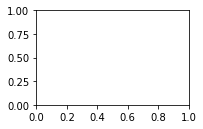

In [16]:
# Start timing
print("Computing posterior PDFs...")
lasttime = time.clock()


# Compute marginal PDFs of mass and age
logm, mpdf = cs.mpdf(0, phot, photerr, filters=filters)
logt, tpdf = cs.mpdf(1, phot, photerr, filters=filters)
logx, xpdf = cs.mpdf(2, phot, photerr, ngrid=1000, filters=filters)

# End timing
newtime = time.clock()
tottime = newtime - lasttime

# Print timing results
print("Computation time: {:f} seconds total, {:f} seconds / PDF".
      format(tottime, tottime/phot.shape[0]/2))

# Set up a plot window
plt.figure(1, figsize=(6,8))
plt.subplot(4,2,1)

In [17]:
# Compute the mean of the posterior PDFs returned by cluster_slug
mmean = np.sum(logm*mpdf*(logm[1]-logm[0]), axis=1)
tmean = np.sum(logt*tpdf*(logt[1]-logt[0]), axis=1)
xmean = np.sum(logx*xpdf*(logx[1]-logt[0]), axis=1)

# Compute the 25th, 50th, and 75th percentiles of the posterior PDFs
mpdfsum = np.cumsum(mpdf, axis=1)*(logm[1]-logm[0])
mpercentiles = np.array([
    logm[np.argmax(np.greater(mpdfsum, 0.1), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.5), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.9), axis=1)]])
tpdfsum = np.cumsum(tpdf, axis=1)*(logt[1]-logt[0])
tpercentiles = np.array([
    logt[np.argmax(np.greater(tpdfsum, 0.1), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.5), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.9), axis=1)]])
xpdfsum = np.cumsum(xpdf, axis=1)*(logx[1]-logx[0])
xpercentiles = np.array([
    logx[np.argmax(np.greater(xpdfsum, 0.1), axis=1)],
    logx[np.argmax(np.greater(xpdfsum, 0.5), axis=1)],
    logx[np.argmax(np.greater(xpdfsum, 0.9), axis=1)]])

In [18]:
# For each model, find the best match in the library for the 12 hand-picked clusters
matches, dist = cs.bestmatch(phot, filters=filters, nmatch=1)
dist = dist/np.sqrt(len(filters))

In [19]:
mp25=mpercentiles[0]
mp50=mpercentiles[1]
mp75=mpercentiles[2]
tp25=tpercentiles[0]
tp50=tpercentiles[1]
tp75=tpercentiles[2]
xp25=xpercentiles[0]
xp50=xpercentiles[1]
xp75=xpercentiles[2]

In [20]:
pmatches, dist = cs.bestmatch(phot, filters=filters, nmatch=100)

In [21]:
matches[:,2:3]

array([[0.81979978],
       [1.30928783],
       [1.86028689],
       ...,
       [1.17329186],
       [0.98065343],
       [0.07144805]])

In [28]:
matches[:,2:3]

array([[0.81979978],
       [1.30928783],
       [1.86028689],
       ...,
       [1.17329186],
       [0.98065343],
       [0.07144805]])

In [29]:
phot_matches=(pmatches[:,:,3:])+dmod_M33
m_matches=matches[:,:1]
t_matches=matches[:,1:2]
x_matches=matches[:,2:3]

In [30]:
#Mass IQR
MassIQR=mpercentiles[2]-mpercentiles[0]
(MassIQR)

array([1.27552948, 1.41725497, 1.37001314, ..., 2.64554262, 1.20466673,
       0.68500657])

In [31]:
#Age IQR
AgeIQR=tpercentiles[2]-tpercentiles[0]
AgeIQR

array([1.07086593, 1.92125945, 2.20472396, ..., 2.42519636, 1.51181072,
       1.03936987])

In [32]:
#Av IQR
AvIQR=xpercentiles[2]-xpercentiles[0]
AvIQR

array([1.13677709, 1.38390255, 1.43332764, ..., 2.02642873, 1.23562727,
       0.64252618])

In [33]:
M33_ClsChi2Vals

ID,Chi2(2)
int32,float64
1,5.5820165699238955e-05
2,2.831436498120221e-07
3,8.5776906548467e-06
4,2.043548933000631e-05
5,3.7982451130408193e-06
6,2.091595919014693e-05
7,2.669871212089093e-06
8,0.0008304491800575871
9,9.871403713734451e-05


In [34]:
m33_Prop_PDF=Table([m33goodphot_2filts['ID'],M33_ClsChi2Vals['Chi2(2)'],
                    mpercentiles[0],mpercentiles[1],mpercentiles[2],MassIQR,tpercentiles[0],
                    tpercentiles[1],tpercentiles[2],AgeIQR,xpercentiles[0],xpercentiles[1],
                    xpercentiles[2],AvIQR],
                   names=('a','b','c','d','e','f','g','h','i','j','k','l','m','n'))
m33_Prop_PDF

a,b,c,d,e,f,g,h,i,j,k,l,m,n
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,5.5820165699238955e-05,2.165355294673551,2.5905317864483943,3.440884769998081,1.27552947532453,6.094488480920338,6.377952990496135,7.165354405984458,1.07086592506412,0.41215843144202857,0.9558344318490339,1.548935523202131,1.1367770917601023
2,2.831436498120221e-07,2.1417343784638376,2.5669108702386807,3.5589893510466486,1.417254972582811,6.094488480920338,6.440945103735201,8.015747934711847,1.9212594537915084,0.46158352238812,1.054684613741217,1.8454860688786794,1.3839025464905594
3,8.5776906548467e-06,2.118113462254124,2.5669108702386807,3.488126602417508,1.3700131401633842,6.157480594159405,6.692913556691464,8.36220455752671,2.2047239633673046,0.3627333404959372,0.9558344318490339,1.796060977932588,1.4333276374366508
4,2.043548933000631e-05,2.259838959512405,3.181054691691232,4.621930580483756,2.362091620971351,6.157480594159405,7.543307085418854,9.43307048259083,3.2755898884314254,0.31330824954984576,1.0052595227951253,2.2903118873935018,1.977003637843656
5,3.7982451130408193e-06,2.1417343784638376,2.5669108702386807,3.488126602417508,1.3463922239536705,6.094488480920338,6.377952990496135,7.511811028799321,1.4173225478789826,0.41215843144202857,1.0052595227951253,1.6477857050943139,1.2356272736522853
6,2.091595919014693e-05,2.165355294673551,2.5905317864483943,3.488126602417508,1.3227713077439573,6.094488480920338,6.377952990496135,7.354330745701656,1.2598422647813177,0.41215843144202857,0.9558344318490339,1.5983606141482223,1.1862021827061937
7,2.669871212089093e-06,2.1889762108832644,2.732257283706675,4.196754088708913,2.007777877825649,6.094488480920338,6.440945103735201,8.519684840624375,2.425196359704037,0.41215843144202857,1.104109704687308,1.8949111598247705,1.482752728382742
8,0.0008304491800575871,2.354322624351259,3.2519174403203728,4.291237753547768,1.936915129196509,6.125984537539872,6.503937216974267,7.669291311896986,1.5433067743571138,0.26388315860375433,0.6592838861724857,1.202959886579491,0.9390767279757367
9,9.871403713734451e-05,2.165355294673551,2.6613945350775348,3.936924010402065,1.771568715728514,6.094488480920338,6.440945103735201,8.36220455752671,2.267716076606371,0.41215843144202857,1.104109704687308,1.9443362507708621,1.5321778193288336


In [35]:
m33_Prop_PDF.rename_column('a', 'ID')
m33_Prop_PDF.rename_column('b', 'Chi_2(2)')
m33_Prop_PDF.rename_column('c', 'Mass_PDF_P25(2)')
m33_Prop_PDF.rename_column('d', 'Mass_PDF_Median(2)')
m33_Prop_PDF.rename_column('e', 'Mass_PDF_P75(2)')
m33_Prop_PDF.rename_column('f', 'MassIQR(2)')
m33_Prop_PDF.rename_column('g', 'Age_PDF_P25(2)')
m33_Prop_PDF.rename_column('h', 'Age_PDF_Median(2)')
m33_Prop_PDF.rename_column('i', 'Age_PDF_P75(2)')
m33_Prop_PDF.rename_column('j', 'Age_IQR(2)')
m33_Prop_PDF.rename_column('k', 'AV_PDF_P25(2)')
m33_Prop_PDF.rename_column('l', 'AV_PDF_Median(2)')
m33_Prop_PDF.rename_column('m', 'AV_PDF_P75(2)')
m33_Prop_PDF.rename_column('n', 'AV_IQR(2)')
m33_Prop_PDF

ID,Chi_2(2),Mass_PDF_P25(2),Mass_PDF_Median(2),Mass_PDF_P75(2),MassIQR(2),Age_PDF_P25(2),Age_PDF_Median(2),Age_PDF_P75(2),Age_IQR(2),AV_PDF_P25(2),AV_PDF_Median(2),AV_PDF_P75(2),AV_IQR(2)
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,5.5820165699238955e-05,2.165355294673551,2.5905317864483943,3.440884769998081,1.27552947532453,6.094488480920338,6.377952990496135,7.165354405984458,1.07086592506412,0.41215843144202857,0.9558344318490339,1.548935523202131,1.1367770917601023
2,2.831436498120221e-07,2.1417343784638376,2.5669108702386807,3.5589893510466486,1.417254972582811,6.094488480920338,6.440945103735201,8.015747934711847,1.9212594537915084,0.46158352238812,1.054684613741217,1.8454860688786794,1.3839025464905594
3,8.5776906548467e-06,2.118113462254124,2.5669108702386807,3.488126602417508,1.3700131401633842,6.157480594159405,6.692913556691464,8.36220455752671,2.2047239633673046,0.3627333404959372,0.9558344318490339,1.796060977932588,1.4333276374366508
4,2.043548933000631e-05,2.259838959512405,3.181054691691232,4.621930580483756,2.362091620971351,6.157480594159405,7.543307085418854,9.43307048259083,3.2755898884314254,0.31330824954984576,1.0052595227951253,2.2903118873935018,1.977003637843656
5,3.7982451130408193e-06,2.1417343784638376,2.5669108702386807,3.488126602417508,1.3463922239536705,6.094488480920338,6.377952990496135,7.511811028799321,1.4173225478789826,0.41215843144202857,1.0052595227951253,1.6477857050943139,1.2356272736522853
6,2.091595919014693e-05,2.165355294673551,2.5905317864483943,3.488126602417508,1.3227713077439573,6.094488480920338,6.377952990496135,7.354330745701656,1.2598422647813177,0.41215843144202857,0.9558344318490339,1.5983606141482223,1.1862021827061937
7,2.669871212089093e-06,2.1889762108832644,2.732257283706675,4.196754088708913,2.007777877825649,6.094488480920338,6.440945103735201,8.519684840624375,2.425196359704037,0.41215843144202857,1.104109704687308,1.8949111598247705,1.482752728382742
8,0.0008304491800575871,2.354322624351259,3.2519174403203728,4.291237753547768,1.936915129196509,6.125984537539872,6.503937216974267,7.669291311896986,1.5433067743571138,0.26388315860375433,0.6592838861724857,1.202959886579491,0.9390767279757367
9,9.871403713734451e-05,2.165355294673551,2.6613945350775348,3.936924010402065,1.771568715728514,6.094488480920338,6.440945103735201,8.36220455752671,2.267716076606371,0.41215843144202857,1.104109704687308,1.9443362507708621,1.5321778193288336


In [36]:
m33_Prop_PDF.write('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M33-Triangulum/Prop_Tables/M33_Prop2filt2129cls.fits')